In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.express as px
import seaborn as sns

# visual setups
plt.style.use('dark_background')  # Set dark background for matplotlib
px.defaults.template = "plotly_dark"

In [2]:
data_path = 'data'
def load(data_folder, filename):
    df = pd.read_csv(os.path.join(data_folder, filename))
    return df

accounts = load(data_path, 'accounts.csv')
products = load(data_path, 'products.csv')
sales_pipeline = load(data_path, 'sales_pipeline.csv')
sales_teams = load(data_path, 'sales_teams.csv')

tables = [accounts, products, sales_pipeline, sales_teams] 

for index, table in enumerate(tables):
    print(f"=============== Details of table {index } ===============")
    print(table.describe(), '\n')
    print(table.info(), '\n')
    print('=' * 100)


=============== Details of table 0 ===============
       year_established       revenue     employees
count         85.000000     85.000000     85.000000
mean        1996.105882   1994.632941   4660.823529
std            8.865427   2169.491436   5715.601198
min         1979.000000      4.540000      9.000000
25%         1989.000000    497.110000   1179.000000
50%         1996.000000   1223.720000   2769.000000
75%         2002.000000   2741.370000   5595.000000
max         2017.000000  11698.030000  34288.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   account           85 non-null     object 
 1   sector            85 non-null     object 
 2   year_established  85 non-null     int64  
 3   revenue           85 non-null     float64
 4   employees         85 non-null     int64  
 5   office_location   85 non-null     object 
 

- Merging the tables

In [3]:
df = sales_pipeline.merge(accounts, on='account', how='left')
df = df.merge(products, on='product', how='left')
df = df.merge(sales_teams, on='sales_agent', how='left')

df.isnull().sum()

sales_pipeline.loc[sales_pipeline['product'].str.contains('GTXPro', case = False), 'product'] = 'GTX Pro'


In [4]:
# Removing all blank customers
df = df.dropna(subset='account')
df.isnull().sum()

opportunity_id         0
sales_agent            0
product                0
account                0
deal_stage             0
engage_date          163
close_date           664
close_value          664
sector                 0
year_established       0
revenue                0
employees              0
office_location        0
subsidiary_of       6083
series              1258
sales_price         1258
manager                0
regional_office        0
dtype: int64

# RFM Analysis

In [5]:
df['close_date'] = pd.to_datetime(df.close_date)
reference_date = df['close_date'].max() + pd.Timedelta(days=1)

# Calculate RFM
rfm = df.groupby('account').agg({
    'close_date': lambda x: (reference_date - x.max()).days,
    'opportunity_id': 'nunique',
    'close_value': 'sum'
}).reset_index()

rfm = rfm.rename(columns={
    'close_date': 'recency',
    'opportunity_id': 'frequency',
    'close_value': 'monetary'
})

# Create quantiles for recency
recency_cuts = pd.qcut(rfm['recency'], q=5, duplicates='drop')
n_bins = recency_cuts.cat.categories.size
recency_labels = list(range(n_bins, 0, -1))

# Now use n_bins instead of 5
rfm['R_Score'] = pd.qcut(rfm['recency'], q=n_bins, labels=recency_labels, duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['frequency'].rank(method='first'), q=n_bins, labels=range(1, n_bins + 1), duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['monetary'].rank(method='first'), q=n_bins, labels=range(1, n_bins + 1), duplicates='drop')


### K-Mean Clustering

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4012\2869928001.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', color='gold')


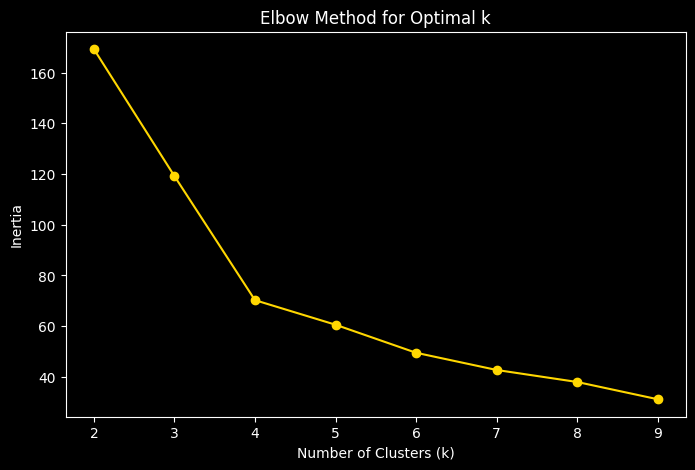

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4012\2869928001.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, sil_scores, 'bo-', color='gold')


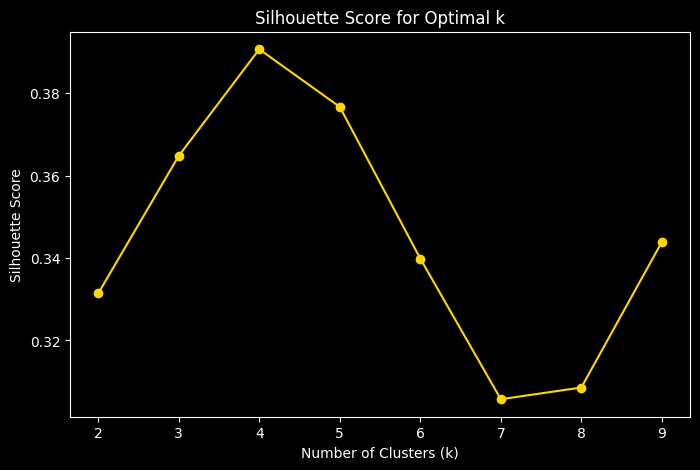

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Prepare data for clustering
rfm_features = rfm[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Elbow Method to find optimal k
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', color='gold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.savefig('images/elbow_plot.png')
plt.show()

# Silhouette Score
sil_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

plt.figure(figsize=(8, 5))
plt.plot(K, sil_scores, 'bo-', color='gold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.savefig('images/silhouette_plot.png')
plt.show()

# Apply K-Means with chosen k (e.g., k=4 based on Elbow/Silhouette)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Save clustered data
#rfm.to_csv('data/rfm_clustered.csv', index=False)

- The elbow method suggests to go with 4 clusters.
- The silhouette method also suggests to go with 4 clusters.

In [7]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm

,account,recency,frequency,monetary,R_Score,F_Score,M_Score,Cluster
0,Acme Corporation,5,68,101744.0,2,2,2,0
1,Betasoloin,4,68,97036.0,2,2,2,0
2,Betatech,3,92,107408.0,3,3,2,2
3,Bioholding,2,94,90991.0,4,3,2,0
4,Bioplex,16,53,67393.0,1,1,1,1
...,...,...,...,...,...,...,...,...
80,Zencorporation,14,58,86690.0,1,1,2,1
81,Zoomit,4,58,76684.0,2,1,1,0
82,Zotware,2,75,138339.0,4,2,3,2
83,Zumgoity,5,63,78237.0,2,1,1,0


- Cluster Analysis

In [8]:
cluster_summary = rfm.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'account': 'count'
}).rename(columns={'account': 'Count'}).reset_index()

cluster_summary

,Cluster,recency,frequency,monetary,Count
0,0,3.666667,67.222222,84173.694444,36
1,1,14.666667,73.000000,109946.888889,9
2,2,3.083333,98.722222,138158.111111,36
3,3,1.750000,186.000000,253016.750000,4


### Explanation

- Recency = Lower days better
- Frequency and Monetary = Higher values better 

### Expected Clusters (based on RFM):
- Cluster 3: This is the best cluster. these customers are highly active and spend the most.

- Cluster 2: Also very good, but slightly less valuable than cluster 3.

- Cluster 0 Good, but lower compared to cluster 2 and 3.

- Cluster 1: Customers buy and spend a decent amount, but they haven't purchased recently. At risk if no re-engaged.


Renaming The cluster to propper tier names:


In [9]:
cluster_names = {
    0: 'Potential Loyalists',
    1: 'Needs Attention',
    2: 'Loyal High-Value Customers',
    3: 'Champions'
}

rfm['Cluster'] = rfm['Cluster'].map(cluster_names)

### Visualizations

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4012\556412218.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_pivot = rfm.groupby(['R_Score', 'F_Score'])['monetary'].mean().unstack()


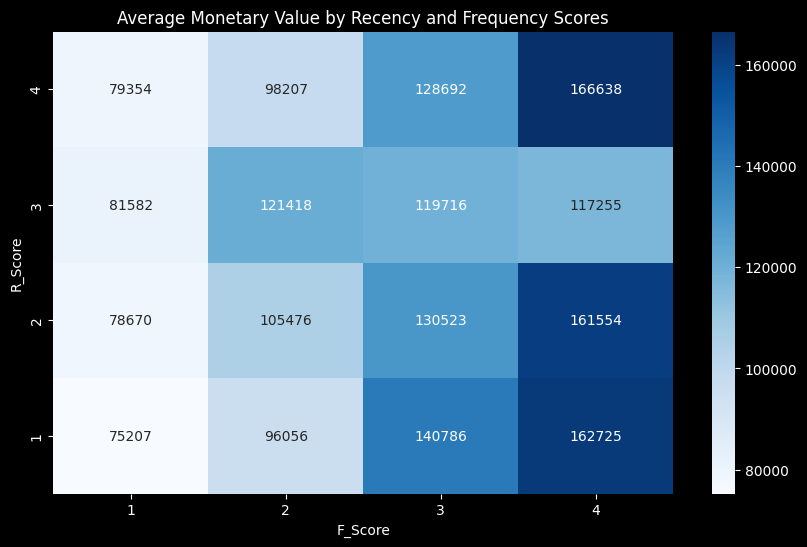

In [10]:
import seaborn as sns

# Pivot table for heatmap
rfm_pivot = rfm.groupby(['R_Score', 'F_Score'])['monetary'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(rfm_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Average Monetary Value by Recency and Frequency Scores')
#plt.savefig('visualizations/rfm_heatmap.png')
plt.savefig("images/heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
fig = px.scatter_3d(rfm, 
                    x='recency', 
                    y='frequency', 
                    z='monetary', 
                    color='Cluster',
                    title='Customer Segments by RFM',
                    width=1000,  # increase width
                    height=500   # increase height
                   )
fig.show()


### PCA

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


features = ['recency', 'frequency', 'monetary']
X = rfm[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)  # Reduce to 2 components (for 2D plot)
X_pca = pca.fit_transform(X_scaled)


pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = rfm['Cluster']  # Add clusters if you want to color by cluster

# apply pca values to rfm table
rfm = pd.concat([rfm, pca_df[['PC1', 'PC2']]], axis=1)

In [13]:
import plotly.express as px

# Define the custom color map
custom_palette = {
    'Potential Loyalists': 'darkblue',
    'Needs Attention': 'purple',
    'Loyal High-Value Customers': '#ED7953',
    'Champions': 'yellow'
}

# Plot using Plotly
fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='Cluster',
    title='Clusters Visualized in PCA Space',
    color_discrete_map=custom_palette,
    template='plotly_dark',
    width=800,
    height=600
)

fig.update_layout(
    legend_title_text='Customer Segment',
    legend=dict(bgcolor='black', font=dict(color='white'))
)

fig.show()


In [14]:
rfm.to_csv('data/rfm_analysis.csv', index = False)